In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# **Configure GPU Acceleration**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

Thu Mar 25 22:15:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10035136589687616099, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10660773902960875991
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [22]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



# **Data Preprocessing**

In [6]:
file_path = '/content/drive/My Drive/Churn_Modelling.csv'

df = pd.read_csv(file_path, index_col='RowNumber').reset_index(drop=True)
print('Dataframe shape :', df.shape)
df.head(3)

Dataframe shape : (10000, 13)


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [7]:
#Retrieve relevant features by excluding : 'CustomerId', 'Surname', 'Exited' 
columns = df.columns.to_list()[2:-1]
X = df[columns]

#Retrieve target column
y = df['Exited']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

In [9]:
categorical_encoder = ColumnTransformer(transformers = [('geo_encoder', OneHotEncoder(drop='first'), ['Geography']),
                                                        ('gen_encoder', OrdinalEncoder(), ['Gender'])], 
                                        remainder = 'passthrough')


pipe = Pipeline(steps = [('encoder', categorical_encoder), 
                         ('scaler', StandardScaler())])

In [10]:
#Split to train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# **Hyperparameter Tuning**

### **Baseline model**

In [12]:
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression()
baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.8113333333333334

### **Regular Neural Network**

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, PReLU
from tensorflow.keras.regularizers import l1, l1_l2
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

def create_model(neurons=10, activation='relu', regularizer=l1(l=0.1), optimizer='adam', dropout_rate=0.0):
  with tf.device('/device:GPU:0'):
    #creation
    model = Sequential()
    model.add(Dense(units=neurons, kernel_initializer='uniform', activation=activation))
    model.add(Dense(units=neurons, kernel_initializer='uniform', kernel_regularizer=regularizer, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    #compilation
    model.compile(optimizer = optimizer , loss='binary_crossentropy', metrics=['accuracy'])

  return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5) 

model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=10, verbose=0)

#### **Tuning** : epochs, batch_size, optimizers 

In [40]:
from sklearn.model_selection import GridSearchCV

batch_size = [10, 20]
epochs = [100, 150]
optimizer = ['adam', 'RMSprop']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=5, verbose=1)

with tf.device('/device:GPU:0'):
  grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed: 33.5min finished


In [41]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.856286 using {'batch_size': 10, 'epochs': 150, 'optimizer': 'adam'}
0.852714 (0.009902) with: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
0.844571 (0.017691) with: {'batch_size': 10, 'epochs': 100, 'optimizer': 'RMSprop'}
0.856286 (0.009405) with: {'batch_size': 10, 'epochs': 150, 'optimizer': 'adam'}
0.853571 (0.009069) with: {'batch_size': 10, 'epochs': 150, 'optimizer': 'RMSprop'}
0.849429 (0.009470) with: {'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}
0.843429 (0.014007) with: {'batch_size': 20, 'epochs': 100, 'optimizer': 'RMSprop'}
0.852429 (0.005761) with: {'batch_size': 20, 'epochs': 150, 'optimizer': 'adam'}
0.852143 (0.011176) with: {'batch_size': 20, 'epochs': 150, 'optimizer': 'RMSprop'}


# **Training model**

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  

#Model Checkpoint
model_chechpoint = ModelCheckpoint(filepath='best_clf.h5', monitor='val_loss', save_best_only=True)

#Create model
clf = create_model()

#Training
fitting = clf.fit(X_train, y_train, 
                  validation_split=0.2, 
                  batch_size=10, 
                  epochs=150, 
                  callbacks= [early_stopping, model_chechpoint],
                  verbose=0)

#Get best classifier
saved_clf = load_model('best_clf.h5')

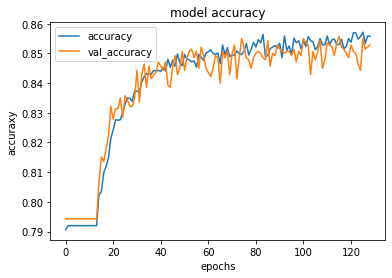

Best Validation Metrics - loss : 0.3719637989997864 - accuracy 0.8557142615318298


In [45]:
#TRAINING ACCURACY HISTORY

plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuraxy')
plt.show()

validation_accuracy = max(fitting.history['val_accuracy'])
validation_loss = min(fitting.history['val_loss'])
print(f"Best Validation Metrics - loss : {validation_loss} - accuracy {validation_accuracy}")

In [60]:
#TESTING ACCURACY

def accuracy(model, X_test, y_test):
  '''Compute the accuracy of of a given model'''
  y_prob_pred = model.predict(X_test)
  y_pred = [int(value) for value in (y_prob_pred > 0.5)]
  return sum([int(value) for value in (y_pred == y_test)])/len(y_test)

clf_accuracy = accuracy(saved_clf, X_test, y_test)
print(f"Model testing accuracy : {clf_accuracy*100:.2f}%")

Model testing accuracy : 86.90%
